In [1]:
import numpy as np
import networkx as nx
from collections import defaultdict
import pandas as pd
from collections import Counter
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import os
import random
import re
import scperturb
from SERGIO._perturbation import perturbation
import SERGIO.optimisation as optimisation
import SERGIO.evaluation as evaluation

create perturbation object

In [4]:
pert = perturbation()
pert.create(100)
%time pert.perturbation_all(nCells=1000)

INFO:root:Number of nodes is 72
1it [01:31, 91.27s/it]


KeyboardInterrupt: 

In [18]:
pert.save()

load previously created perturbation object

In [2]:
folder = 'data'
pattern = r'pert_(\d+)_(\d+)\.pkl'  # pattern to match file names

data = []
for file in os.listdir(folder):
    match = re.match(pattern, file)
    if match:
        nGenes, nCells = match.groups()
        data.append({'file': file, 'nGenes': int(nGenes), 'nCells': int(nCells)})
df = pd.DataFrame(data)
df.set_index('file')

,nGenes,nCells
file,,
pert_24_10000.pkl,24,10000
pert_70_10000.pkl,70,10000
pert_17_1000.pkl,17,1000


In [3]:
pert = perturbation().load(nGenes=70,nCells=10000)

In [4]:
G = pert.G
store = pert.store
wt = pert.wt
grn = pert.grn0

In [5]:
store.shape,wt.shape
gene_list = list(grn.attr_['genes'].keys())

inspect those genes.
The second gene in the tuple is known to have in-degree 1

In [6]:
[([*G.predecessors(k)][0],k) for k,v in dict(G.in_degree()).items() if v ==1]


[('54', '4'),
 ('16', '63'),
 ('17', '34'),
 ('18', '25'),
 ('55', '20'),
 ('63', '22'),
 ('23', '41'),
 ('38', '26'),
 ('28', '51'),
 ('28', '57'),
 ('29', '40'),
 ('68', '35'),
 ('51', '36'),
 ('39', '58'),
 ('41', '60'),
 ('42', '59'),
 ('52', '64')]

draw network containing 'gene_view', its successors and their other parents

54


,from,to,weight
0,54,4,3.138688
1,54,5,3.702105
2,54,31,2.987882
3,54,66,3.907134


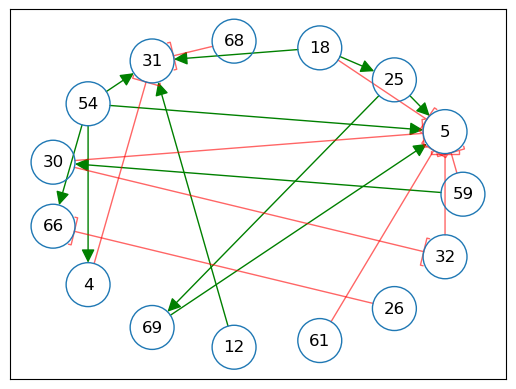

In [7]:
gene_view = '54'#gene_list[1]

print(gene_view)


two_step_neigh = {*itertools.chain.from_iterable([set(G.predecessors(g)) for g in set(G.successors(gene_view))])}
#plt.figure(figsize=(8,8))
pert.draw_net(G.subgraph(two_step_neigh.union(G.successors(gene_view)).union({gene_view})))
pd.DataFrame([[a,b,d['weight']] for a,b,d in list(G.out_edges(gene_view,data=True))],columns=[['from','to','weight']])

(array([12., 23., 27., 17., 23.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0., 17., 19., 29., 13., 22.]),
 array([-3.98581364e+00, -3.58761871e+00, -3.18942378e+00, -2.79122886e+00,
        -2.39303393e+00, -1.99483900e+00, -1.59664408e+00, -1.19844915e+00,
        -8.00254222e-01, -4.02059294e-01, -3.86436746e-03,  3.94330560e-01,
         7.92525487e-01,  1.19072041e+00,  1.58891534e+00,  1.98711027e+00,
         2.38530519e+00,  2.78350012e+00,  3.18169505e+00,  3.57988998e+00,
         3.97808490e+00]),
 <BarContainer object of 20 artists>)

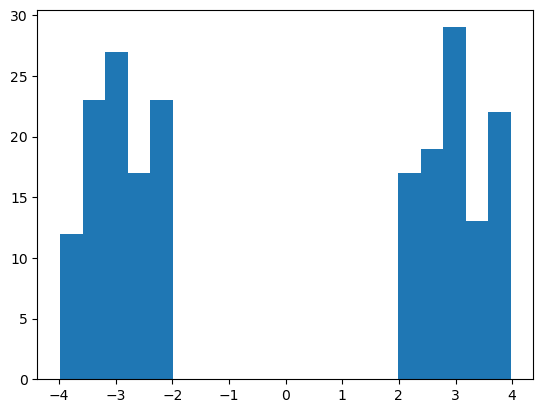

In [25]:
w = [el['weight'] for el in list(zip(*G.edges(data = True)))[2]]
plt.hist(list(w),20)

Investigate expression on the target gene

<AxesSubplot:ylabel='Density'>

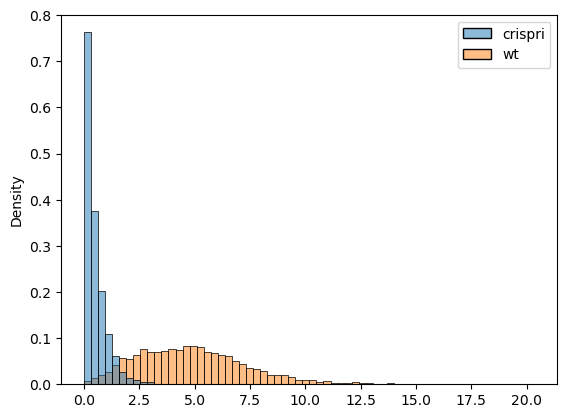

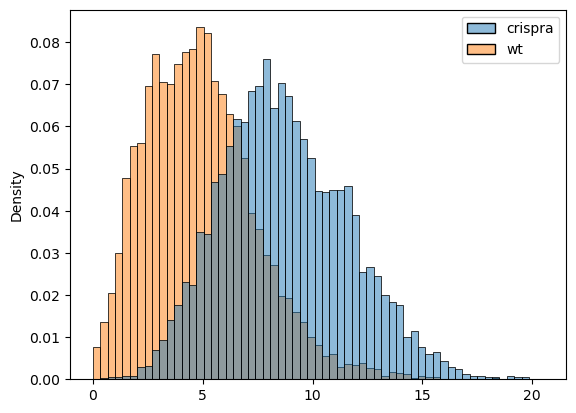

In [8]:
i = np.arange(len(gene_list))[np.array(gene_list)==gene_view][0]# take the index of gene_view
#j = np.arange(len(gene_list))[np.array(gene_list)==list(G.out_edges(gene_view))[0][1]][0]#take the index of one of the genes neighbouring gene_view
j = i
a = pd.DataFrame({'crispri':store[0,i,j],'wt':wt[j]})
sns.histplot(a,stat='density')
plt.figure()
a = pd.DataFrame({'crispra':store[1,i,j],'wt':wt[j]})
sns.histplot(a,stat='density')


investigate on direct neighbours

<AxesSubplot:ylabel='Density'>

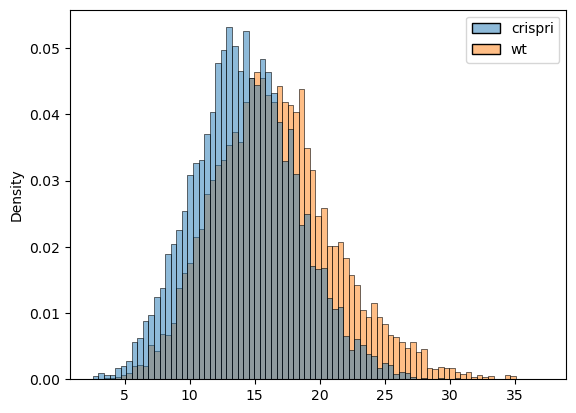

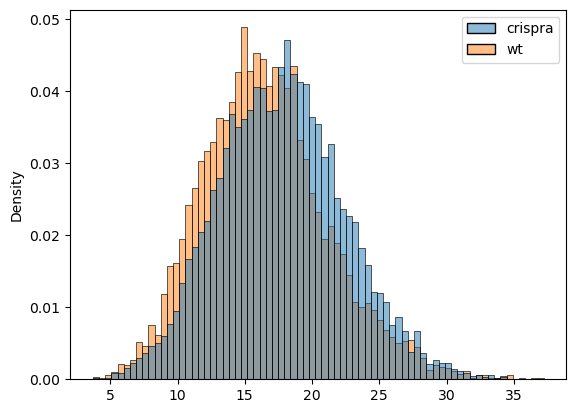

In [9]:
i = np.arange(len(gene_list))[np.array(gene_list)==gene_view][0]# take the index of gene_view
j = np.arange(len(gene_list))[np.array(gene_list)=='5'][0]#take the index of one of the genes neighbouring gene_view
#j = i
a = pd.DataFrame({'crispri':store[0,i,j],'wt':wt[j]})
sns.histplot(a,stat='density')
plt.figure()
a = pd.DataFrame({'crispra':store[1,i,j],'wt':wt[j]})
sns.histplot(a,stat='density')


## Evaluate performance of our inference method on Sergio simulated dataset

In [10]:
class pseudobulk():
    def __init__(self) -> None:
        pass
    def mean(self,store,wt):
        self.crispri,self.crispra = store.mean(axis = 3)
        self.wt = wt.mean(axis=1)
        return self
    def normalise(self):
        def transformation(x):
            return 1-np.exp(-x)
        normalised = pseudobulk() # create a copy of the current instance
        normalised.crispri = transformation(self.crispri)
        normalised.crispra = transformation(self.crispra)
        normalised.wt = transformation(self.wt)
        return normalised

pseudo = pseudobulk().mean(store,wt)
pseudo =  pseudo.normalise()

In [30]:
P_w,_ = optimisation.belief_propagation_pert_short(pseudo.wt,pseudo.crispri,pseudo.crispra,T = 1,theta=0.0,lam=1,J0 = 3,
                                                   beta=10)

INFO:root:finishing after 20 iterations
INFO:root:finishing after 20 iterations
INFO:root:finishing after 20 iterations
INFO:root:finishing after 19 iterations
INFO:root:finishing after 21 iterations
INFO:root:finishing after 19 iterations
INFO:root:finishing after 23 iterations
INFO:root:finishing after 22 iterations
INFO:root:finishing after 18 iterations
INFO:root:finishing after 20 iterations
INFO:root:finishing after 20 iterations
INFO:root:finishing after 20 iterations
INFO:root:finishing after 18 iterations
INFO:root:finishing after 21 iterations
INFO:root:finishing after 23 iterations
INFO:root:finishing after 18 iterations
INFO:root:finishing after 21 iterations
INFO:root:finishing after 22 iterations
INFO:root:finishing after 18 iterations
INFO:root:finishing after 19 iterations
INFO:root:finishing after 19 iterations
INFO:root:finishing after 20 iterations
INFO:root:finishing after 21 iterations
INFO:root:finishing after 21 iterations
INFO:root:finishing after 21 iterations


Random model AUPR for class 1is: 0.020703933747412008
Random model AUPR for class 0is: 0.9581780538302277
Random model AUPR for class -1is: 0.02111801242236025


/tmp/ipykernel_183308/908034802.py:1: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  J_ref = J = nx.adjacency_matrix(G).T


{1: 0.5123488372093024, 0: 0.4956763394576277, -1: 0.4618107395242361}

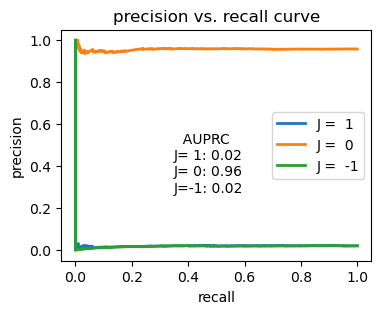

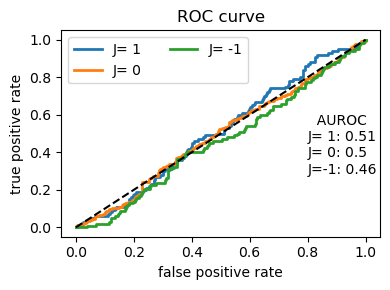

In [31]:
J_ref = J = nx.adjacency_matrix(G).T
J_ref.data = np.where(J_ref.data>0,1,-1)
evaluation.ROC(P_w=P_w,J = J_ref)

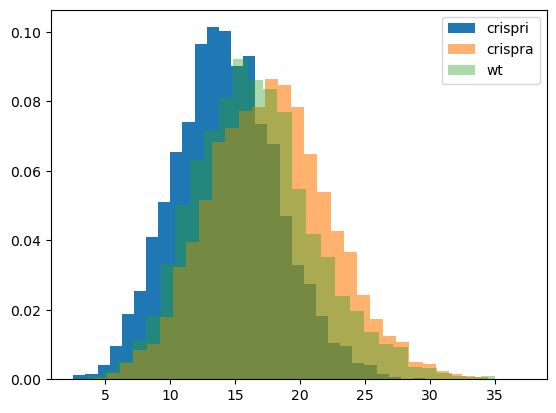

In [65]:
h,b,_ = plt.hist(store[0,i,j],bins =30,label = 'crispri',density = True)

h,b,_ = plt.hist(store[1,i,j],alpha = 0.6,bins = 30,label = 'crispra',density = True)
h,b,_ = plt.hist(wt[j],alpha = 0.4,bins = 30,label = 'wt',density = True)
plt.legend()

In [164]:
pd.DataFrame([[i,v.prod_rates_[0]] for i,v in sim2.grn_.attr_['genes'].items()if v.prod_rates_ is not None] ,columns= ['MR_id','prod_rate'])

,MR_id,prod_rate
0,2737,3.582154
1,4853,4.081881
2,900,5.000000
3,7161,1.538699
4,3135,2.003430
5,3164,1.158086
6,9572,2.282716
7,5598,1.877689
8,5602,4.718141
9,50674,2.268740


In [129]:
sim2.grn_.attr_['genes'][gene]._calc_prod([0], regs_conc = 'sim')
sim2.grn_.attr_['genes'][gene].prod_rates_

array([5.])

In [13]:
sim2.grn_.attr_['genes'][gene].isMR_,sim.grn_.attr_['genes'][gene].isMR_


(True, False)

In [30]:
if sim2.grn_.attr_['genes'][list(non_mr)[0]].prod_rates_ is not None:
    print('None')

None


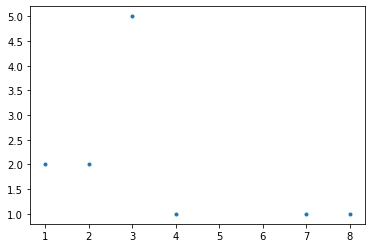

In [156]:
sim2.grn_.attr_['genes'][gene].level,
plt.plot(*zip(*list(Counter([sim2.grn_.attr_['genes'][el].level for el in mrs ]).items())),'.')


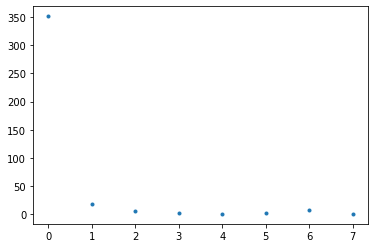

run etest on Anndata, create a unique anndata with perturbation column. Use p-values to compare with experiments

In [32]:
import scanpy as sc
scperturb.edist_to_control

<function scperturb.edistance.edist_to_control(adata, obs_key='perturbation', control='control', obsm_key='X_pca', dist='sqeuclidean', flavor=0, verbose=True)>

In [105]:

def perturbation_to_anndata(wt,store):
    n_wt = wt.shape[1]
    crispri = store[0]
    crispra = store[1]
    n_cells = n_wt+np.prod(np.array(crispri.shape)[np.array([0,1])])
    obs = pd.DataFrame(np.concatenate((['control']*n_wt,['perturbation']*(n_cells-n_wt))))
    data = np.reshape(crispri,(np.prod(np.array(crispri.shape)[[0,2]]),np.array(crispri.shape)[1])).T
    var = pd.DataFrame(np.array(np.arange(crispri.shape[1]),dtype = 'str'))
    return obs,var,data
    
obs,var,data =perturbation_to_anndata(wt,store)
#sc.AnnData(X = data,obs = obs,var = var)
obs.shape,var.shape,data.shape


((14900, 1), (70, 1), (70, 700000))

In [42]:
def edist_to_control(adata, obs_key='perturbation', control='control', 
                     obsm_key='X_pca', dist='sqeuclidean',  
                     flavor=0, verbose=True):
    """Computes the edistance to control.
    Computes the all E-distances between all groups of cells defined in
    adata.obs[obs_key] (e.g. perturbations) and control cells. Distances are computed in embedding
    space given by adata.obsm[obsm_key] (e.g. PCA space).
    Arguments
    ---------
    adata: :class:`~anndata.AnnData`
        Annotated data matrix.
    obs_key: `str` in adata.obs.keys() (default: `perturbation`)
        Key in adata.obs specifying the groups to consider.
    obsm_key: `str` in adata.obsm (default: `adata.obsm['X_pca']`)
        Key for embedding coordinates to use.
    dist: `str` for any distance in scipy.spatial.distance (default: `sqeuclidean`)
        Distance metric to use in embedding space.
    flavor: `int` (default: `0`)
        Which flavor of E-distance to use.
        - `0`: E-distance no correction factor
        - `1`: E-distance with simple correction factor (N-1)
        - `2`: E-distance with correction factor NM/(N+M)
        - `3`: E-distance with correction division by delta
    verbose: `bool` (default: `True`)
        Whether to show a progress bar iterating over all groups.
    Returns
    -------
    ed_to_c: pandas.DataFrame
        DataFrame with E-distances between all groups and control group.
    """
    correction_factor = flavor==1
    deltas_to_c = onesided_pca_distances(adata, obs_key=obs_key, control=control, 
                                         obsm_key=obsm_key, dist=dist, 
                                         correction_factor=correction_factor, 
                                         verbose=verbose)
    sigmas = self_pca_distances(adata, obs_key, obsm_key=obsm_key, dist=dist, 
                                correction_factor=correction_factor, verbose=False)
    # derive basic statistics
    ed_to_c = 2 * deltas_to_c - sigmas - sigmas.loc[control]
    if flavor == 2:
        sizes = np.array([np.sum(adata.obs[obs_key]==g) for g in sigmas.index])
        corrections = (sizes * sizes[sigmas.index==control]) / (sizes + sizes[sigmas.index==control])
        ed_to_c = ed_to_c * corrections.reshape(-1,1)
    if flavor == 3:
        ed_to_c = ed_to_c / deltas_to_c
    return ed_to_c

In [2]:
pert = perturbation(50)
pert.perturbation_all(nCells=10)

/home/giuseppe/Documents/Sergio_perturbation/SERGIO/_perturbation.py:157: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  J = nx.adjacency_matrix(G)
DEBUG:root:Number of nodes is 33


KeyboardInterrupt: 

In [7]:
import pickle
pickle.dump?

In [4]:
pert.load('pert_10')

In [5]:
pert.store

array([[[[0.00000000e+00, 1.07644500e-01, 2.00254368e-01,
          3.15047724e-02, 0.00000000e+00, 9.91562830e-02,
          2.00254368e-01, 1.52326733e-01, 1.45232398e-01,
          2.12374233e-01],
         [3.87152751e+00, 3.82110445e+00, 4.20384171e+00,
          2.72978465e+00, 4.14533028e+00, 3.66240337e+00,
          4.20384171e+00, 3.49483939e+00, 4.19844366e+00,
          3.17552036e+00],
         [7.19312223e+00, 8.16663076e+00, 8.28894991e+00,
          7.67124380e+00, 8.02660001e+00, 7.51668214e+00,
          8.28894991e+00, 6.31544570e+00, 8.52381962e+00,
          6.26944109e+00],
         [1.27698252e-01, 4.37413958e-01, 1.01735568e-01,
          6.53540987e-02, 5.10127547e-01, 6.07956638e-01,
          1.01735568e-01, 5.91108159e-01, 7.41290822e-02,
          6.32171083e-01],
         [1.58445139e+00, 1.08792231e+00, 1.22927771e+00,
          1.53669167e+00, 1.52341030e+00, 7.96520363e-01,
          1.22927771e+00, 9.10082770e-01, 1.46160539e+00,
          9.54253707e-